In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
from scipy.stats import norm

In [6]:
def exact_terzaghi_solution(z, t, H, k, mv, delta_sigma, N_terms=100):
    """
    Exact solution to 1D Terzaghi consolidation with double drainage.

    Parameters:
        z : float or np.ndarray    - depth coordinate(s) [m], 0 <= z <= H
        t : float or np.ndarray    - time(s) [s]
        H : float                  - half-thickness of soil layer [m]
        k : float                  - hydraulic conductivity [m/s]
        mv : float                 - coefficient of volume compressibility [m²/kN]
        delta_sigma : float       - applied load increment [kPa]
        N_terms : int              - number of terms in series (default 100)

    Returns:
        u : float or np.ndarray    - excess pore water pressure [kPa]
    """
    gamma_w = 9.81  # unit weight of water [kN/m³]
    Cv = k / (mv * gamma_w)  # coefficient of consolidation [m²/s]

    u = np.zeros_like(np.broadcast(z, t), dtype=np.float64)
    pi = np.pi

    for n in range(N_terms):
        m = 2 * n + 1
        term = (1 / (m * pi)) * np.sin(m * pi * z / (2 * H)) * \
               np.exp(-((m * pi)**2 * Cv * t) / (4 * H**2))
        u += term

    u *= 4 * delta_sigma
    return u

In [7]:
def degree_of_consolidation(t, H, k, mv, N_terms=100):
    gamma_w = 9.81  # kN/m³
    Cv = k / (mv * gamma_w)
    U = np.zeros_like(t, dtype=np.float64)
    pi = np.pi

    for n in range(N_terms):
        m = 2 * n + 1
        term = (8 / (m**2 * pi**2)) * np.exp(-(m * pi)**2 * Cv * t / (4 * H**2))
        U += term

    return 1 - U

def total_settlement(t, H, k, mv, delta_sigma, N_terms=100):
    U = degree_of_consolidation(t, H, k, mv, N_terms)
    s_inf = mv * delta_sigma * H
    return s_inf * U  # m


In [8]:
def total_settlement_3layer(t, H1, H2, H3,
                            k1, k2, k3,
                            mv1, mv2, mv3,
                            delta_sigma, N_terms=100):
    """
    Compute total settlement for 3 soil layers under Terzaghi 1D consolidation.

    Parameters:
        t : float or np.ndarray  - time [s]
        H1, H2, H3 : floats       - thicknesses [m]
        k1, k2, k3 : floats       - permeability [m/s]
        mv1, mv2, mv3 : floats    - compressibility [m²/kN]
        delta_sigma : float       - load increment [kPa]
    Returns:
        s_total(t): float or np.ndarray [m]
    """
    s1 = total_settlement(t, H1, k1, mv1, delta_sigma, N_terms)
    s2 = total_settlement(t, H2, k2, mv2, delta_sigma, N_terms)
    s3 = total_settlement(t, H3, k3, mv3, delta_sigma, N_terms)
    return s1 + s2 + s3


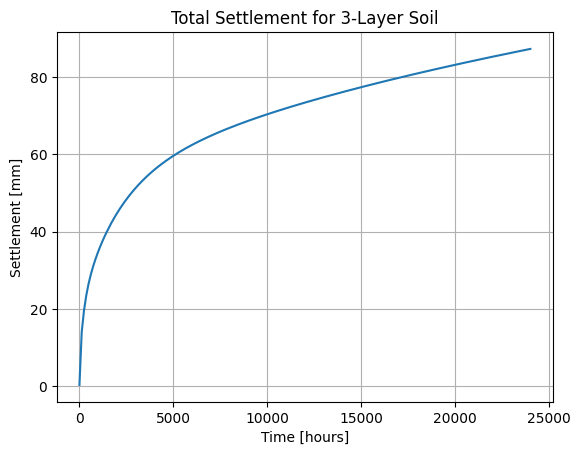

In [ ]:
t = np.linspace(0, 1000 * 24 * 3600, 200)  # 10 days
s = total_settlement_3layer(t,
                            H1=10, H2=0, H3=0,
                            k1=1e-8, k2=5e-9, k3=1e-9,
                            mv1=0.0005, mv2=0.001, mv3=0.002,
                            delta_sigma=10.0,
                            N_terms=100)

plt.plot(t / 3600, s * 1000)
plt.xlabel("Time [hours]")
plt.ylabel("Settlement [mm]")
plt.title("Total Settlement for 3-Layer Soil")
plt.grid(True)
plt.show()

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
XPINN for 1D three-layered Terzaghi consolidation in PyTorch.
Solves ∂u/∂t = c_v ∂²u/∂x² in each layer with interface continuity.
Includes example run at the end.
"""
import time
import numpy as np
torch = __import__('torch')
import torch.nn as nn
import torch.autograd as autograd

# MLP backbone
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers)-2):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(nn.Tanh())
        layer_list.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        return self.model(X)

# XPINN container
class XPINN1D:
    def __init__(self, cv, layers):
        # cv: list of consolidation coeff [cv1,cv2,cv3]
        self.cv1, self.cv2, self.cv3 = cv
        self.net1 = MLP(layers[0])
        self.net2 = MLP(layers[1])
        self.net3 = MLP(layers[2])
        self.params = list(self.net1.parameters()) + list(self.net2.parameters()) + list(self.net3.parameters())
        self.optimizer = torch.optim.Adam(self.params, lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def pde_residual(self, net, x, t, cv):
        x = x.clone().requires_grad_(True)
        t = t.clone().requires_grad_(True)
        u = net(x, t)
        u_t = autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return u_t - cv * u_xx

    def interface_terms(self, x_i, t_i, netA, netB, cvA, cvB):
        x_i = x_i.clone().requires_grad_(True)
        t_i = t_i.clone().requires_grad_(True)
        uA = netA(x_i, t_i)
        uB = netB(x_i, t_i)
        uA_x = autograd.grad(uA, x_i, grad_outputs=torch.ones_like(uA), create_graph=True)[0]
        uB_x = autograd.grad(uB, x_i, grad_outputs=torch.ones_like(uB), create_graph=True)[0]
        cont = uA - uB
        flux = cvA * uA_x - cvB * uB_x
        return cont, flux

    def loss(self, data):
        x_ic1, t_ic1, u_ic1 = data['ic1']
        x_ic2, t_ic2, u_ic2 = data['ic2']
        x_ic3, t_ic3, u_ic3 = data['ic3']
        x_bt, t_bt, u_bt = data['bc_top']
        x_bb, t_bb, u_bb = data['bc_bot']
        x_f1, t_f1 = data['f1']
        x_f2, t_f2 = data['f2']
        x_f3, t_f3 = data['f3']
        x_i12, t_i12 = data['i12']
        x_i23, t_i23 = data['i23']

        # IC losses
        loss_ic = self.loss_fn(self.net1(x_ic1, t_ic1), u_ic1)
        loss_ic += self.loss_fn(self.net2(x_ic2, t_ic2), u_ic2)
        loss_ic += self.loss_fn(self.net3(x_ic3, t_ic3), u_ic3)
        # BC losses
        loss_bc = self.loss_fn(self.net1(x_bt, t_bt), u_bt)
        loss_bc += self.loss_fn(self.net3(x_bb, t_bb), u_bb)
        # PDE residuals
        f1 = self.pde_residual(self.net1, x_f1, t_f1, self.cv1)
        f2 = self.pde_residual(self.net2, x_f2, t_f2, self.cv2)
        f3 = self.pde_residual(self.net3, x_f3, t_f3, self.cv3)
        loss_pde = self.loss_fn(f1, torch.zeros_like(f1))
        loss_pde += self.loss_fn(f2, torch.zeros_like(f2))
        loss_pde += self.loss_fn(f3, torch.zeros_like(f3))
        # Interface terms
        cont12, flux12 = self.interface_terms(x_i12, t_i12, self.net1, self.net2, self.cv1, self.cv2)
        cont23, flux23 = self.interface_terms(x_i23, t_i23, self.net2, self.net3, self.cv2, self.cv3)
        loss_if = self.loss_fn(cont12, torch.zeros_like(cont12)) + self.loss_fn(flux12, torch.zeros_like(flux12))
        loss_if += self.loss_fn(cont23, torch.zeros_like(cont23)) + self.loss_fn(flux23, torch.zeros_like(flux23))
        # Total
        return loss_ic + loss_bc + loss_pde + loss_if

    def train(self, data, nIter=2000):
        for it in range(1, nIter+1):
            self.optimizer.zero_grad()
            L = self.loss(data)
            L.backward()
            self.optimizer.step()
            if it % 500 == 0:
                print(f"Iter {it}, Loss = {L.item():.3e}")

    def predict(self, x, t):
        self.net1.eval(); self.net2.eval(); self.net3.eval()
        with torch.no_grad():
            u1 = self.net1(x, t).cpu().numpy()
            u2 = self.net2(x, t).cpu().numpy()
            u3 = self.net3(x, t).cpu().numpy()
        return u1, u2, u3

# Running example
if __name__ == "__main__":
    # Problem setup
    H1, H2, H3 = 1.0, 1.0, 1.0
    T_max = 1.0
    cv = [1e-2, 5e-3, 2e-3]
    layers = [[2, 32, 32, 1], [2, 32, 32, 1], [2, 32, 32, 1]]
    # Data sizes
    N_ic, N_bc, N_f, N_i = 200, 200, 1000, 200
    # Initial conditions: u=1
    def ic_points(H):
        x = torch.rand(N_ic,1)*H
        t = torch.zeros_like(x)
        u = torch.ones_like(x)
        return x, t, u
    x_ic1, t_ic1, u_ic1 = ic_points(H1)
    x_ic2, t_ic2, u_ic2 = ic_points(H2)
    x_ic3, t_ic3, u_ic3 = ic_points(H3)
    # Boundary conditions
    t_bc = torch.rand(N_bc,1)*T_max
    x_bt = torch.zeros_like(t_bc)
    u_bt = torch.zeros_like(t_bc)
    x_bb = H1+H2+H3 * torch.ones_like(t_bc)
    u_bb = torch.zeros_like(t_bc)
    # Collocation
    def f_points(x0, x1):
        x = x0 + (x1-x0)*torch.rand(N_f,1)
        t = T_max*torch.rand(N_f,1)
        return x, t
    x_f1, t_f1 = f_points(0, H1)
    x_f2, t_f2 = f_points(H1, H1+H2)
    x_f3, t_f3 = f_points(H1+H2, H1+H2+H3)
    # Interfaces
    t_i = torch.rand(N_i,1)*T_max
    x_i12 = H1 * torch.ones_like(t_i)
    x_i23 = (H1+H2) * torch.ones_like(t_i)
    # Package data
    data = {
        'ic1': (x_ic1, t_ic1, u_ic1),
        'ic2': (x_ic2, t_ic2, u_ic2),
        'ic3': (x_ic3, t_ic3, u_ic3),
        'bc_top': (x_bt, t_bc, u_bt),
        'bc_bot': (x_bb, t_bc, u_bb),
        'f1': (x_f1, t_f1), 'f2': (x_f2, t_f2), 'f3': (x_f3, t_f3),
        'i12': (x_i12, t_i), 'i23': (x_i23, t_i)
    }
    # Check if CUDA is available
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # Move data to the appropriate device
    for key, val in data.items():
        data[key] = tuple(v.to(device) for v in val)
    
    # Instantiate and train
    model = XPINN1D(cv, layers)
    model.net1.to(device)
    model.net2.to(device)
    model.net3.to(device)
    start = time.time()
    model.train(data, nIter=2000)
    print(f"Training time: {time.time()-start:.2f}s")

Iter 500, Loss = 4.004e-02
Iter 1000, Loss = 2.086e-02
Iter 1500, Loss = 1.478e-02
Iter 2000, Loss = 1.165e-02
Training time: 38.50s


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [27]:
# Test prediction at mid-times
x_test = torch.tensor([[0.5],[1.5],[2.5]], dtype=torch.float32)  # Changed to float32
t_test = torch.tensor([[0.2],[0.5],[0.8]], dtype=torch.float32)  # Changed to float32
if torch.cuda.is_available(): 
    x_test, t_test = x_test.cuda(), t_test.cuda()
u1p, u2p, u3p = model.predict(x_test, t_test)
print("Sample predictions u1, u2, u3:")
print(np.hstack([u1p, u2p, u3p]))


Sample predictions u1, u2, u3:
[[1.0120144  1.0303134  1.0329354 ]
 [0.9446929  0.8030368  0.8271698 ]
 [0.92859894 0.36627007 0.29583508]]


Iter 500, Loss = 2.597e-01
Iter 1000, Loss = 7.129e-02
Iter 1500, Loss = 3.649e-02
Iter 2000, Loss = 2.739e-02
Training time: 41.32s


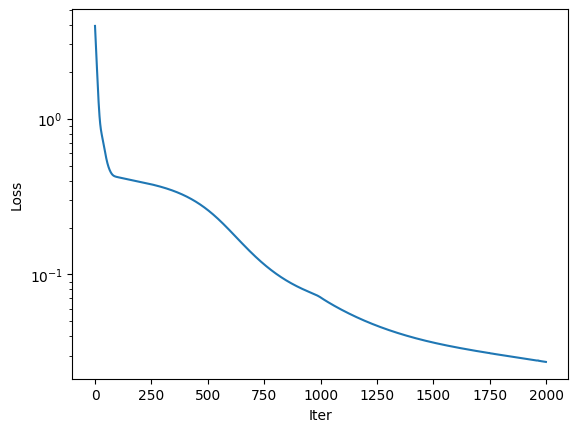

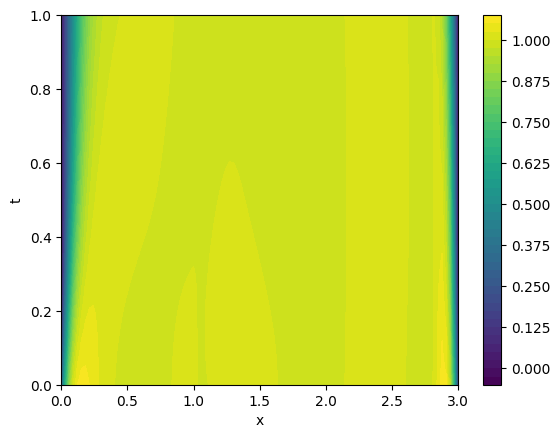

In [47]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
XPINN for 1D three-layered Terzaghi consolidation in PyTorch.
Solves ∂u/∂t = c_v ∂²u/∂x² in each layer with interface continuity.
Includes example run at the end, with loss curve and solution plot.
This version correctly maps global x into each subnetwork's local coordinate.
"""
import time
import numpy as np
import matplotlib.pyplot as plt
torch = __import__('torch')
import torch.nn as nn
import torch.autograd as autograd

# MLP backbone
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers)-2):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(nn.Tanh())
        layer_list.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        return self.model(X)

# XPINN container
class XPINN1D:
    def __init__(self, cv, H_layers, layers, device):
        self.device = device
        self.cv1, self.cv2, self.cv3 = cv
        self.H1, self.H2, self.H3 = H_layers
        self.net1 = MLP(layers[0]).to(device)
        self.net2 = MLP(layers[1]).to(device)
        self.net3 = MLP(layers[2]).to(device)
        self.params = list(self.net1.parameters()) + list(self.net2.parameters()) + list(self.net3.parameters())
        self.optimizer = torch.optim.Adam(self.params, lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def _u1(self, x, t):
        return self.net1(x, t)
    def _u2(self, x, t):
        # shift global x into layer2 local [0,H2]
        return self.net2(x - self.H1, t)
    def _u3(self, x, t):
        # shift global x into layer3 local [0,H3]
        return self.net3(x - (self.H1 + self.H2), t)

    def pde_residual(self, u_fun, x, t, cv):
        xg = x.clone().requires_grad_(True)
        tg = t.clone().requires_grad_(True)
        u = u_fun(xg, tg)
        u_t = autograd.grad(u, tg, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = autograd.grad(u, xg, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, xg, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return u_t - cv * u_xx

    def interface_terms(self, x_i, t_i, uA_fun, uB_fun, cvA, cvB):
        xi = x_i.clone().requires_grad_(True)
        ti = t_i.clone().requires_grad_(True)
        uA = uA_fun(xi, ti)
        uB = uB_fun(xi, ti)
        uA_x = autograd.grad(uA, xi, grad_outputs=torch.ones_like(uA), create_graph=True)[0]
        uB_x = autograd.grad(uB, xi, grad_outputs=torch.ones_like(uB), create_graph=True)[0]
        cont = uA - uB
        flux = cvA * uA_x - cvB * uB_x
        return cont, flux

    def loss(self, data):
        # unpack data
        (x_ic1, t_ic1, u_ic1) = data['ic1']
        (x_ic2, t_ic2, u_ic2) = data['ic2']
        (x_ic3, t_ic3, u_ic3) = data['ic3']
        (x_bt, t_bt, u_bt) = data['bc_top']
        (x_bb, t_bb, u_bb) = data['bc_bot']
        (x_f1, t_f1) = data['f1']
        (x_f2, t_f2) = data['f2']
        (x_f3, t_f3) = data['f3']
        (x_i12, t_i12) = data['i12']
        (x_i23, t_i23) = data['i23']

        # initial condition losses (local inputs already)
        loss_ic = self.loss_fn(self.net1(x_ic1, t_ic1), u_ic1)
        loss_ic += self.loss_fn(self.net2(x_ic2, t_ic2), u_ic2)
        loss_ic += self.loss_fn(self.net3(x_ic3, t_ic3), u_ic3)

        # boundary conditions (map bottom)
        loss_bc = self.loss_fn(self._u1(x_bt, t_bt), u_bt)
        loss_bc += self.loss_fn(self._u3(x_bb, t_bb), u_bb)

        # PDE residuals
        f1 = self.pde_residual(self._u1, x_f1, t_f1, self.cv1)
        f2 = self.pde_residual(self._u2, x_f2, t_f2, self.cv2)
        f3 = self.pde_residual(self._u3, x_f3, t_f3, self.cv3)
        loss_pde = self.loss_fn(f1, torch.zeros_like(f1))
        loss_pde += self.loss_fn(f2, torch.zeros_like(f2))
        loss_pde += self.loss_fn(f3, torch.zeros_like(f3))

        # interface continuity
        cont12, flux12 = self.interface_terms(x_i12, t_i12, self._u1, self._u2, self.cv1, self.cv2)
        cont23, flux23 = self.interface_terms(x_i23, t_i23, self._u2, self._u3, self.cv2, self.cv3)
        loss_if = self.loss_fn(cont12, torch.zeros_like(cont12))
        loss_if += self.loss_fn(flux12, torch.zeros_like(flux12))
        loss_if += self.loss_fn(cont23, torch.zeros_like(cont23))
        loss_if += self.loss_fn(flux23, torch.zeros_like(flux23))

        return loss_ic + loss_bc + loss_pde + loss_if

    def train(self, data, nIter=2000):
        loss_history = []
        t0 = time.time()
        for it in range(1, nIter+1):
            self.optimizer.zero_grad()
            L = self.loss(data)
            L.backward()
            self.optimizer.step()
            loss_history.append(L.item())
            if it % 500 == 0:
                print(f"Iter {it}, Loss = {L.item():.3e}")
        print(f"Training time: {time.time()-t0:.2f}s")
        return loss_history

    def predict(self, x, t):
        self.net1.eval(); self.net2.eval(); self.net3.eval()
        with torch.no_grad():
            xg = x.to(self.device); tg = t.to(self.device)
            u1 = self._u1(xg, tg).cpu().numpy()
            u2 = self._u2(xg, tg).cpu().numpy()
            u3 = self._u3(xg, tg).cpu().numpy()
        return u1, u2, u3

# Running example
if __name__ == "__main__":
    # layer thicknesses and params
    H1, H2, H3 = 1.0, 1.0, 1.0
    cv = [1e-2, 5e-3, 2e-3]
    layers = [[2,32,32,1], [2,32,32,1], [2,32,32,1]]
    N_ic, N_bc, N_f, N_i = 200,200,1000,200
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Functions to sample data
    def ic_points(H):
        x = torch.rand(N_ic,1)*H
        t = torch.zeros_like(x)
        u = torch.ones_like(x)
        return x.to(device), t.to(device), u.to(device)
    x_ic1,t_ic1,u_ic1 = ic_points(H1)
    x_ic2,t_ic2,u_ic2 = ic_points(H2)
    x_ic3,t_ic3,u_ic3 = ic_points(H3)

    t_bc = torch.rand(N_bc,1)*1.0
    x_bt = torch.zeros_like(t_bc); x_bb = (H1+H2+H3)*torch.ones_like(t_bc)
    u_bt = torch.zeros_like(t_bc); u_bb = torch.zeros_like(t_bc)
    x_bt,t_bc,u_bt = x_bt.to(device), t_bc.to(device), u_bt.to(device)
    x_bb,t_bc,u_bb = x_bb.to(device), t_bc.to(device), u_bb.to(device)

    def f_points(x0,x1):
        x = x0 + (x1-x0)*torch.rand(N_f,1)
        t = torch.rand(N_f,1)
        return x.to(device), t.to(device)
    x_f1,t_f1 = f_points(0,H1)
    x_f2,t_f2 = f_points(H1,H1+H2)
    x_f3,t_f3 = f_points(H1+H2,H1+H2+H3)

    t_i = torch.rand(N_i,1)
    x_i12 = H1*torch.ones_like(t_i)
    x_i23 = (H1+H2)*torch.ones_like(t_i)
    x_i12,t_i12 = x_i12.to(device), t_i.to(device)
    x_i23,t_i23 = x_i23.to(device), t_i.to(device)

    data = {
        'ic1':(x_ic1,t_ic1,u_ic1), 'ic2':(x_ic2,t_ic2,u_ic2), 'ic3':(x_ic3,t_ic3,u_ic3),
        'bc_top':(x_bt,t_bc,u_bt), 'bc_bot':(x_bb,t_bc,u_bb),
        'f1':(x_f1,t_f1), 'f2':(x_f2,t_f2), 'f3':(x_f3,t_f3),
        'i12':(x_i12,t_i12), 'i23':(x_i23,t_i23)
    }

    model = XPINN1D(cv, (H1,H2,H3), layers, device)
    loss_hist = model.train(data, nIter=2000)

    # plot loss
    plt.figure(); plt.plot(loss_hist); plt.yscale('log'); plt.xlabel('Iter'); plt.ylabel('Loss'); plt.show()

    # contour solution
    Nx,Nt = 100,100
    x_vals = np.linspace(0,H1+H2+H3,Nx)
    t_vals = np.linspace(0,1,Nt)
    X,Tt = np.meshgrid(x_vals,t_vals)
    U = np.zeros_like(X)
    for i in range(Nt):
        xt = torch.tensor(X[i,:],dtype=torch.float32).unsqueeze(1)
        tt = torch.tensor(Tt[i,:],dtype=torch.float32).unsqueeze(1)
        u1,u2,u3 = model.predict(xt, tt)
        mask1 = X[i,:]<=H1
        mask2 = (X[i,:]>H1)&(X[i,:]<=H1+H2)
        mask3 = X[i,:]>H1+H2
        U[i,mask1] = u1[mask1].flatten()
        U[i,mask2] = u2[mask2].flatten()
        U[i,mask3] = u3[mask3].flatten()
    plt.figure(); cs=plt.contourf(X,Tt,U,levels=50); plt.colorbar(cs); plt.xlabel('x'); plt.ylabel('t'); plt.show()


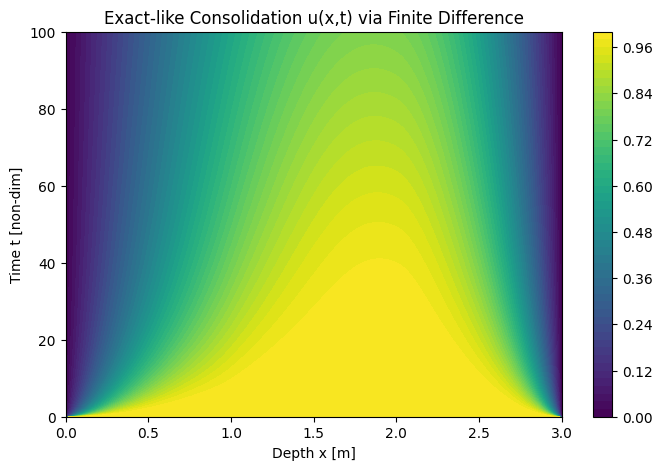

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Domain parameters
H1, H2, H3 = 1.0, 1.0, 1.0
total_H = H1 + H2 + H3
T_max = 100

# Consolidation coefficients
cv1, cv2, cv3 = 1e-2, 5e-3, 2e-3

# Discretization
dx = 0.01
dt = 0.001  # satisfies stability dt <= dx^2/(2*max(cv))
Nx = int(total_H/dx) + 1
Nt = int(T_max/dt) + 1

x = np.linspace(0, total_H, Nx)
t = np.linspace(0, T_max, Nt)

# Piecewise cv array
cv = np.zeros(Nx)
for i in range(Nx):
    if x[i] <= H1:
        cv[i] = cv1
    elif x[i] <= H1 + H2:
        cv[i] = cv2
    else:
        cv[i] = cv3

# Initialize solution: u(x,0) = 1
U = np.zeros((Nt, Nx))
U[0, :] = 1.0
# Boundary conditions: u(0,t) = u(3,t) = 0
U[:, 0] = 0.0
U[:, -1] = 0.0

# Time stepping (FTCS)
for n in range(0, Nt-1):
    for j in range(1, Nx-1):
        U[n+1, j] = U[n, j] + cv[j] * dt/dx**2 * (U[n, j+1] - 2*U[n, j] + U[n, j-1])

# Create meshgrid for plotting
X, Tt = np.meshgrid(x, t)

# Plot contour of u(x,t)
plt.figure(figsize=(8, 5))
cs = plt.contourf(X, Tt, U, levels=50)
plt.colorbar(cs)
plt.xlabel('Depth x [m]')
plt.ylabel('Time t [non-dim]')
plt.title('Exact-like Consolidation u(x,t) via Finite Difference')
plt.show()


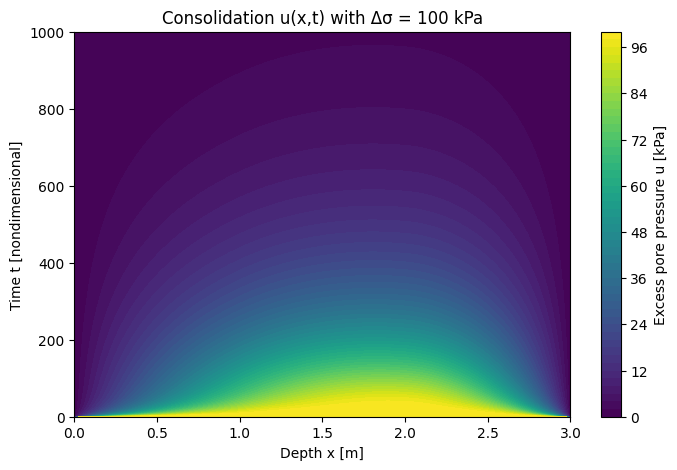

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Domain parameters
H1, H2, H3 = 1.0, 1.0, 1.0
total_H = H1 + H2 + H3
# Define delta sigma (load) in kPa
delta_sigma = 100.0

# Nondimensional time horizon
T_max = 1000.0

# Consolidation coefficients for each layer [m^2/s]
cv1, cv2, cv3 = 1e-2, 5e-3, 2e-3

# Discretization parameters
Nx = 151                     # grid points in x
dx = total_H / (Nx - 1)
# Stability: dt <= 0.5 * dx^2 / max(cv)
dt = 0.5 * dx**2 / max(cv1, cv2, cv3)
Nt = int(T_max / dt) + 1

x = np.linspace(0, total_H, Nx)
t = np.linspace(0, T_max, Nt)

# Build piecewise cv array
cv = np.zeros(Nx)
cv[x <= H1] = cv1
cv[(x > H1) & (x <= H1 + H2)] = cv2
cv[x > H1 + H2] = cv3

# Initialize U: u(x,0) = delta_sigma
U = np.zeros((Nt, Nx))
U[0, :] = delta_sigma

# Boundary conditions: u(0,t) = u(3,t) = 0
U[:, 0] = 0.0
U[:, -1] = 0.0

# Time stepping (vectorized FTCS)
r = cv * dt / dx**2
for n in range(Nt - 1):
    U[n+1, 1:-1] = U[n, 1:-1] + r[1:-1] * (U[n, 2:] - 2*U[n, 1:-1] + U[n, :-2])

# Meshgrid for plotting
X, Tt = np.meshgrid(x, t)

# Plot
plt.figure(figsize=(8, 5))
cs = plt.contourf(X, Tt, U, levels=50, cmap='viridis')
plt.colorbar(cs, label='Excess pore pressure u [kPa]')
plt.xlabel('Depth x [m]')
plt.ylabel('Time t [nondimensional]')
plt.title('Consolidation u(x,t) with Δσ = 100 kPa')
plt.show()


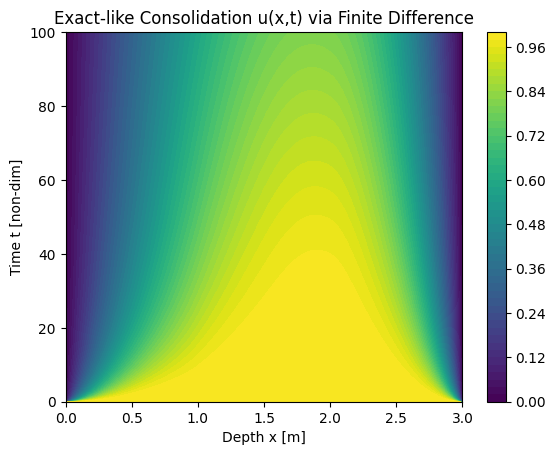

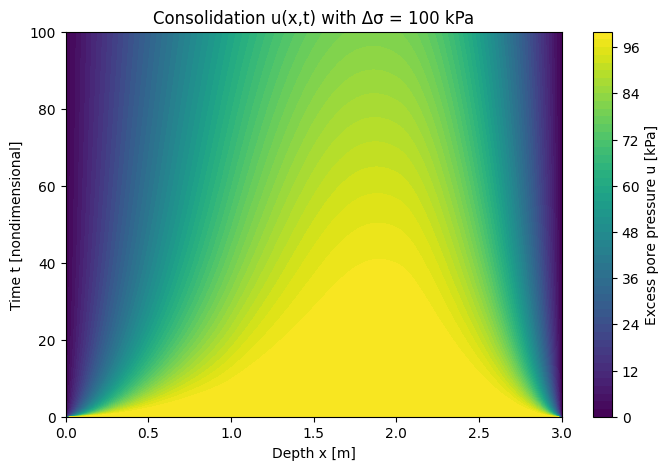

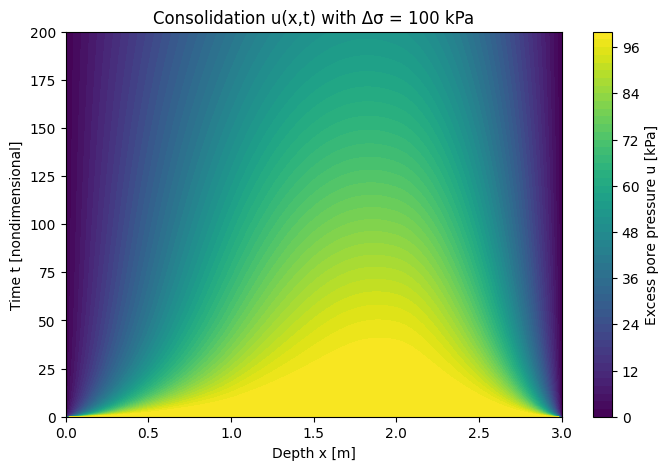

Iter 500, Loss=1.629e+04
Iter 1000, Loss=8.048e+03
Iter 1500, Loss=4.419e+03
Iter 2000, Loss=2.534e+03
Training time: 41.54s


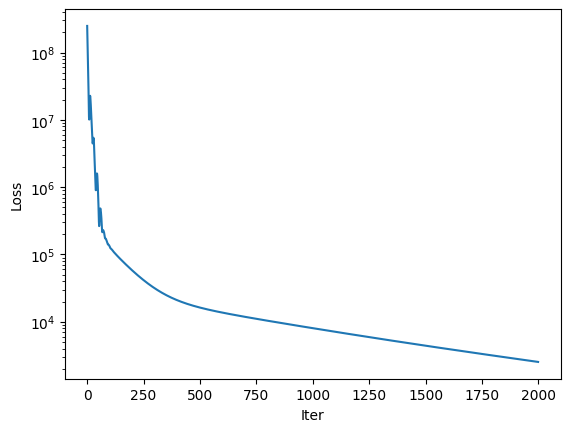

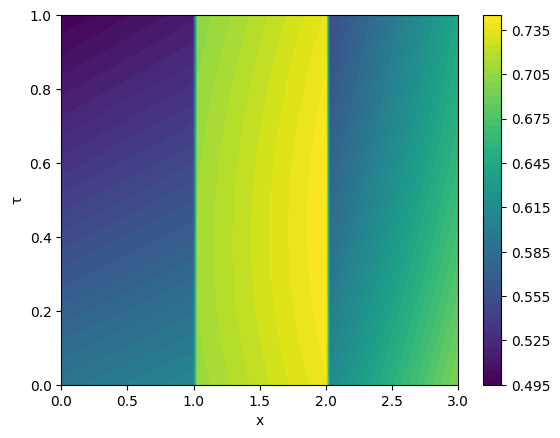

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
XPINN for 1D three-layered Terzaghi consolidation in PyTorch.
Solves ∂u/∂τ = α ∂²u/∂x² in each layer with interface continuity.
Uses dimensionless time τ = t_phys / t_max_phys.
Includes example run, with loss curve and solution plot.
"""
import time
import numpy as np
import matplotlib.pyplot as plt
torch = __import__('torch')
import torch.nn as nn
import torch.autograd as autograd

# MLP backbone
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers)-2):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(nn.Tanh())
        layer_list.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        return self.model(X)

# XPINN container
class XPINN1D:
    def __init__(self, alpha, H_layers, layers, device):
        self.device = device
        # dimensionless PDE coefficients
        self.alpha1, self.alpha2, self.alpha3 = alpha
        self.H1, self.H2, self.H3 = H_layers
        # networks
        self.net1 = MLP(layers[0]).to(device)
        self.net2 = MLP(layers[1]).to(device)
        self.net3 = MLP(layers[2]).to(device)
        self.params = list(self.net1.parameters()) + list(self.net2.parameters()) + list(self.net3.parameters())
        self.optimizer = torch.optim.Adam(self.params, lr=1e-3)
        self.loss_fn = nn.MSELoss()

    # local evaluations
    def _u1(self, x, t): return self.net1(x, t)
    def _u2(self, x, t): return self.net2(x - self.H1, t)
    def _u3(self, x, t): return self.net3(x - (self.H1 + self.H2), t)

    def pde_residual(self, u_fun, x, t, alpha):
        xg = x.clone().requires_grad_(True)
        tg = t.clone().requires_grad_(True)
        u = u_fun(xg, tg)
        u_t = autograd.grad(u, tg, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = autograd.grad(u, xg, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, xg, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return u_t - alpha * u_xx

    def interface_terms(self, x_i, t_i, uA, uB, alphaA, alphaB):
        xi = x_i.clone().requires_grad_(True)
        ti = t_i.clone().requires_grad_(True)
        uA_val = uA(xi, ti)
        uB_val = uB(xi, ti)
        uA_x = autograd.grad(uA_val, xi, grad_outputs=torch.ones_like(uA_val), create_graph=True)[0]
        uB_x = autograd.grad(uB_val, xi, grad_outputs=torch.ones_like(uB_val), create_graph=True)[0]
        cont = uA_val - uB_val
        flux = alphaA * uA_x - alphaB * uB_x
        return cont, flux

    def loss(self, data):
        # unpack
        (x1,t1,u1) = data['ic1']; (x2,t2,u2) = data['ic2']; (x3,t3,u3) = data['ic3']
        (xb_t,tt_t,ub_t) = data['bc_top']; (xb_b,tt_b,ub_b) = data['bc_bot']
        (xf1,tf1),(xf2,tf2),(xf3,tf3) = data['f1'],data['f2'],data['f3']
        (xi12,ti12),(xi23,ti23) = data['i12'],data['i23']

        loss_ic = self.loss_fn(self._u1(x1,t1),u1) + self.loss_fn(self._u2(x2,t2),u2) + self.loss_fn(self._u3(x3,t3),u3)
        loss_bc = self.loss_fn(self._u1(xb_t,tt_t),ub_t) + self.loss_fn(self._u3(xb_b,tt_b),ub_b)

        f1 = self.pde_residual(self._u1, xf1, tf1, self.alpha1)
        f2 = self.pde_residual(self._u2, xf2, tf2, self.alpha2)
        f3 = self.pde_residual(self._u3, xf3, tf3, self.alpha3)
        loss_pde = self.loss_fn(f1,torch.zeros_like(f1)) + self.loss_fn(f2,torch.zeros_like(f2)) + self.loss_fn(f3,torch.zeros_like(f3))

        c12,flux12 = self.interface_terms(xi12,ti12,self._u1,self._u2,self.alpha1,self.alpha2)
        c23,flux23 = self.interface_terms(xi23,ti23,self._u2,self._u3,self.alpha2,self.alpha3)
        loss_if = self.loss_fn(c12,torch.zeros_like(c12))+self.loss_fn(flux12,torch.zeros_like(flux12))
        loss_if += self.loss_fn(c23,torch.zeros_like(c23))+self.loss_fn(flux23,torch.zeros_like(flux23))

        return loss_ic + loss_bc + loss_pde + loss_if

    def train(self,data,nIter=2000):
        hist=[]; t0=time.time()
        for it in range(1,nIter+1):
            self.optimizer.zero_grad(); L=self.loss(data); L.backward(); self.optimizer.step()
            hist.append(L.item())
            if it%500==0: print(f"Iter {it}, Loss={L.item():.3e}")
        print(f"Training time: {time.time()-t0:.2f}s")
        return hist

    def predict(self,x,t):
        self.net1.eval();self.net2.eval();self.net3.eval()
        with torch.no_grad():
            xg, tg = x.to(self.device), t.to(self.device)
            u1 = self._u1(xg,tg).cpu().numpy()
            u2 = self._u2(xg,tg).cpu().numpy()
            u3 = self._u3(xg,tg).cpu().numpy()
        return u1,u2,u3

# Example run
if __name__=="__main__":
    # Physical inputs
    H1,H2,H3 = 1.0,1.0,1.0; H=H1+H2+H3
    t_phys_max = 1000.0  # days
    # cv in m2/s → convert to m2/day
    cv_phys = [1e-2*86400,5e-3*86400,2e-3*86400]
    alpha = [cv_phys[i]*t_phys_max/H**2 for i in range(3)]

    # PINN setup
    layers=[[2,32,32,1]]*3
    N_ic,N_bc,N_f,N_i=200,200,1000,200
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data samplers (dimensionless τ)
    def ic_pts(H): x=torch.rand(N_ic,1)*H; t=torch.zeros_like(x); u=torch.ones_like(x); return x.to(device),t.to(device),u.to(device)
    x_ic1,t_ic1,u_ic1=ic_pts(H1); x_ic2,t_ic2,u_ic2=ic_pts(H2); x_ic3,t_ic3,u_ic3=ic_pts(H3)

    def bc_pts(): t=torch.rand(N_bc,1); x0=torch.zeros_like(t); xH=H*torch.ones_like(t); u0=torch.zeros_like(t); return (x0,t,u0),(xH,t,u0)
    (x_bt,tt_bt,ubt),(x_bb,tt_bb,ubb)=bc_pts()
    x_bt,tt_bt,ubt=x_bt.to(device),tt_bt.to(device),ubt.to(device)
    x_bb,tt_bb,ubb=x_bb.to(device),tt_bb.to(device),ubb.to(device)

    def f_pts(x0,x1): x=x0+(x1-x0)*torch.rand(N_f,1); t=torch.rand(N_f,1); return x.to(device),t.to(device)
    xf1,tf1=f_pts(0,H1); xf2,tf2=f_pts(H1,H1+H2); xf3,tf3=f_pts(H1+H2,H)

    t_i=torch.rand(N_i,1)
    xi12=(H1*torch.ones_like(t_i)).to(device); xi23=((H1+H2)*torch.ones_like(t_i)).to(device)
    ti12=t_i.to(device); ti23=t_i.to(device)

    data={'ic1':(x_ic1,t_ic1,u_ic1),'ic2':(x_ic2,t_ic2,u_ic2),'ic3':(x_ic3,t_ic3,u_ic3),
          'bc_top':(x_bt,tt_bt,ubt),'bc_bot':(x_bb,tt_bb,ubb),
          'f1':(xf1,tf1),'f2':(xf2,tf2),'f3':(xf3,tf3),
          'i12':(xi12,ti12),'i23':(xi23,ti23)}

    model=XPINN1D(alpha,(H1,H2,H3),layers,device)
    hist=model.train(data,2000)

    # plot loss
    plt.figure();plt.plot(hist);plt.yscale('log');plt.xlabel('Iter');plt.ylabel('Loss');plt.show()

    # solution contour
    Nx,Nt=100,100
    x_vals=np.linspace(0,H,Nx); t_vals=np.linspace(0,1,Nt)
    X,Tt=np.meshgrid(x_vals,t_vals); U=np.zeros_like(X)
    for i in range(Nt):
        xt=torch.tensor(X[i,:],dtype=torch.float32).unsqueeze(1)
        tt=torch.tensor(Tt[i,:],dtype=torch.float32).unsqueeze(1)
        u1,u2,u3=model.predict(xt,tt)
        mask1=X[i,:]<=H1; mask2=(X[i,:]>H1)&(X[i,:]<=H1+H2); mask3=X[i,:]>H1+H2
        U[i,mask1]=u1[mask1].flatten(); U[i,mask2]=u2[mask2].flatten(); U[i,mask3]=u3[mask3].flatten()
    plt.figure();cs=plt.contourf(X,Tt,U,levels=50);plt.colorbar(cs);plt.xlabel('x');plt.ylabel('τ');plt.show()
|

It: 0, Loss1: 3.398e+02, Loss2: 2.318e+00, Loss3: 1.359e+01, L2_err2: 1.064e+00, L2_err3: 1.047e+00
It: 20, Loss1: 2.741e+02, Loss2: 1.899e+00, Loss3: 1.259e+01, L2_err2: 1.062e+00, L2_err3: 9.574e-01
It: 40, Loss1: 1.863e+02, Loss2: 2.471e+00, Loss3: 1.287e+01, L2_err2: 6.897e-01, L2_err3: 7.309e-01
It: 60, Loss1: 8.981e+01, Loss2: 3.680e+00, Loss3: 1.553e+01, L2_err2: 1.433e-01, L2_err3: 3.249e-01
It: 80, Loss1: 4.685e+01, Loss2: 3.375e+00, Loss3: 1.569e+01, L2_err2: 6.595e-01, L2_err3: 1.854e-01
It: 100, Loss1: 3.600e+01, Loss2: 2.175e+00, Loss3: 1.390e+01, L2_err2: 7.577e-01, L2_err3: 2.061e-01
It: 120, Loss1: 3.161e+01, Loss2: 1.368e+00, Loss3: 1.340e+01, L2_err2: 8.023e-01, L2_err3: 2.675e-01
It: 140, Loss1: 2.926e+01, Loss2: 1.163e+00, Loss3: 1.289e+01, L2_err2: 7.978e-01, L2_err3: 3.048e-01
It: 160, Loss1: 2.745e+01, Loss2: 9.918e-01, Loss3: 1.080e+01, L2_err2: 7.733e-01, L2_err3: 3.064e-01
It: 180, Loss1: 2.501e+01, Loss2: 8.739e-01, Loss3: 7.096e+00, L2_err2: 7.021e-01, L2_er

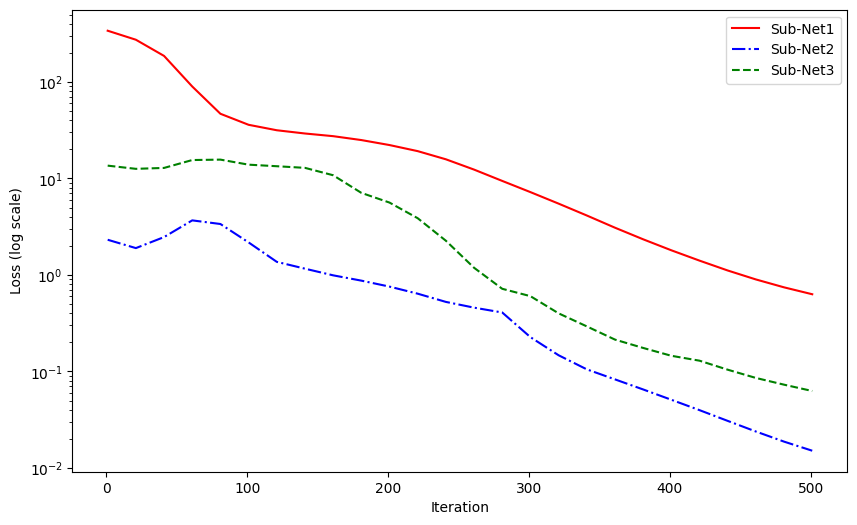

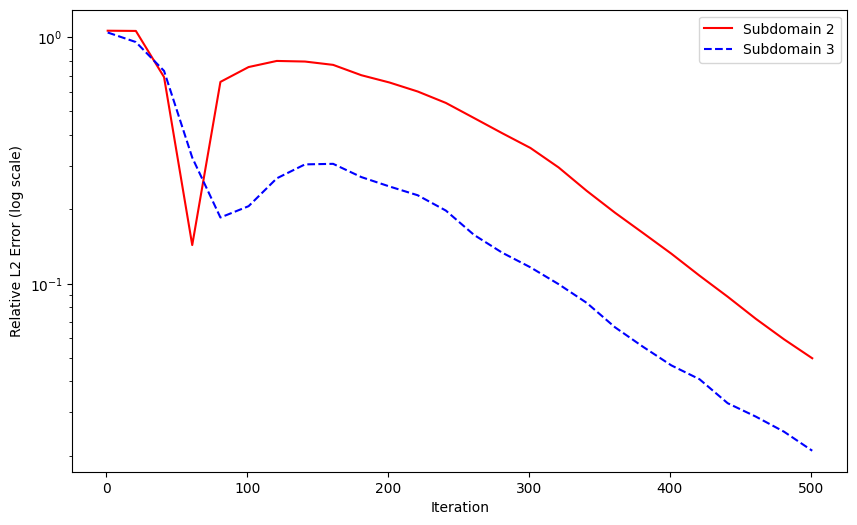

C:\Users\jolu2\AppData\Local\Temp\ipykernel_18332\1476462493.py:326: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))


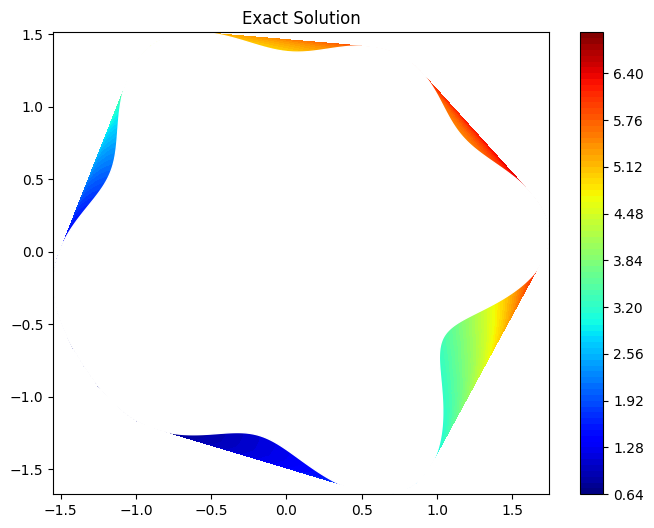

C:\Users\jolu2\AppData\Local\Temp\ipykernel_18332\1476462493.py:334: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))


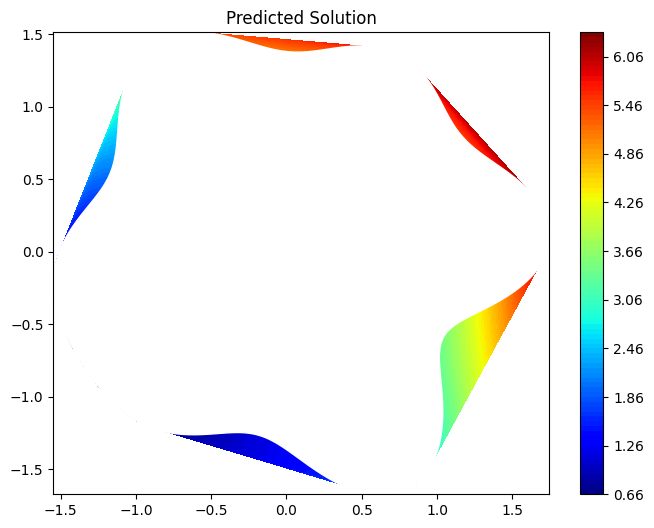

C:\Users\jolu2\AppData\Local\Temp\ipykernel_18332\1476462493.py:342: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))


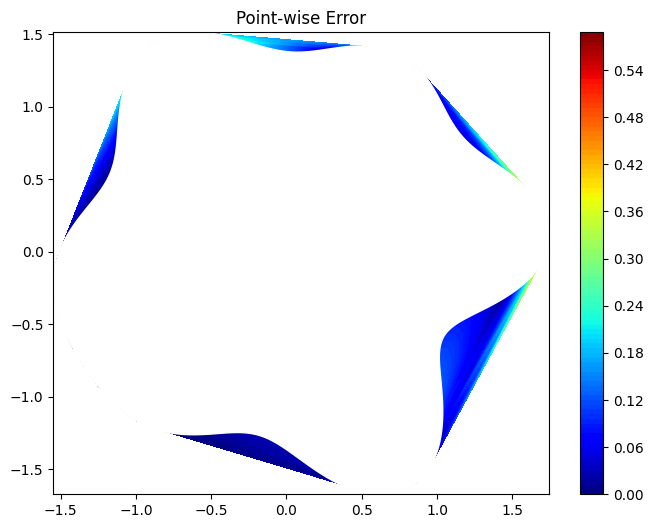

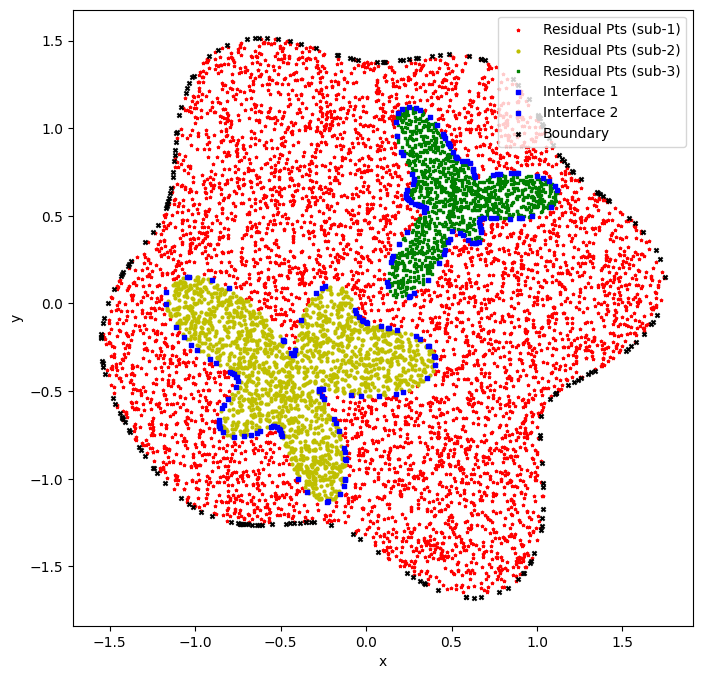

In [48]:
import sys
import time
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class MLP_Module(nn.Module):
    def __init__(self, layers, act='tanh'):
        super(MLP_Module, self).__init__()
        self.layers = layers
        self.linears = nn.ModuleList()
        self.A = nn.ParameterList()
        for i in range(len(layers)-1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
            # scale parameter for adaptive activation
            a = nn.Parameter(torch.tensor(0.05, dtype=torch.float64))
            self.A.append(a)
        self.act = act

    def forward(self, x):
        H = x
        for i, lin in enumerate(self.linears[:-1]):
            W_out = lin(H)
            scaled = 20.0 * self.A[i] * W_out
            if self.act == 'tanh':
                H = torch.tanh(scaled)
            elif self.act == 'sin':
                H = torch.sin(scaled)
            elif self.act == 'cos':
                H = torch.cos(scaled)
        # last layer
        Y = self.linears[-1](H)
        return Y

class XPINN:
    def __init__(self, X_ub, ub, X_f1, X_f2, X_f3, X_fi1, X_fi2,
                 layers1, layers2, layers3):
        # training data
        self.x_ub = torch.tensor(X_ub[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_ub = torch.tensor(X_ub[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.ub   = torch.tensor(ub, dtype=torch.float64, device=device)
        self.x_f1 = torch.tensor(X_f1[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_f1 = torch.tensor(X_f1[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_f2 = torch.tensor(X_f2[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_f2 = torch.tensor(X_f2[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_f3 = torch.tensor(X_f3[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_f3 = torch.tensor(X_f3[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_fi1 = torch.tensor(X_fi1[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_fi1 = torch.tensor(X_fi1[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_fi2 = torch.tensor(X_fi2[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_fi2 = torch.tensor(X_fi2[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        # nets
        self.net1 = MLP_Module(layers1, act='tanh').to(device)
        self.net2 = MLP_Module(layers2, act='sin').to(device)
        self.net3 = MLP_Module(layers3, act='cos').to(device)
        # optimizers
        self.opt1 = optim.Adam(self.net1.parameters(), lr=8e-4)
        self.opt2 = optim.Adam(self.net2.parameters(), lr=8e-4)
        self.opt3 = optim.Adam(self.net3.parameters(), lr=8e-4)

    def net_u1(self, x, y):
        return self.net1(torch.cat([x, y], dim=1))

    def net_u2(self, x, y):
        return self.net2(torch.cat([x, y], dim=1))

    def net_u3(self, x, y):
        return self.net3(torch.cat([x, y], dim=1))

    def net_f(self):
        # auto-diff for PDE residuals and interface conditions
        u1 = self.net_u1(self.x_f1, self.y_f1)
        grads1 = torch.autograd.grad(u1, [self.x_f1, self.y_f1],
                                     grad_outputs=torch.ones_like(u1), create_graph=True)
        u1_x, u1_y = grads1
        u1_xx = torch.autograd.grad(u1_x, self.x_f1, grad_outputs=torch.ones_like(u1_x), create_graph=True)[0]
        u1_yy = torch.autograd.grad(u1_y, self.y_f1, grad_outputs=torch.ones_like(u1_y), create_graph=True)[0]
        f1 = u1_xx + u1_yy - (torch.exp(self.x_f1) + torch.exp(self.y_f1))

        u2 = self.net_u2(self.x_f2, self.y_f2)
        grads2 = torch.autograd.grad(u2, [self.x_f2, self.y_f2],
                                     grad_outputs=torch.ones_like(u2), create_graph=True)
        u2_x, u2_y = grads2
        u2_xx = torch.autograd.grad(u2_x, self.x_f2, grad_outputs=torch.ones_like(u2_x), create_graph=True)[0]
        u2_yy = torch.autograd.grad(u2_y, self.y_f2, grad_outputs=torch.ones_like(u2_y), create_graph=True)[0]
        f2 = u2_xx + u2_yy - (torch.exp(self.x_f2) + torch.exp(self.y_f2))

        u3 = self.net_u3(self.x_f3, self.y_f3)
        grads3 = torch.autograd.grad(u3, [self.x_f3, self.y_f3],
                                     grad_outputs=torch.ones_like(u3), create_graph=True)
        u3_x, u3_y = grads3
        u3_xx = torch.autograd.grad(u3_x, self.x_f3, grad_outputs=torch.ones_like(u3_x), create_graph=True)[0]
        u3_yy = torch.autograd.grad(u3_y, self.y_f3, grad_outputs=torch.ones_like(u3_y), create_graph=True)[0]
        f3 = u3_xx + u3_yy - (torch.exp(self.x_f3) + torch.exp(self.y_f3))

        # interface 1
        u1i1 = self.net_u1(self.x_fi1, self.y_fi1)
        u2i1 = self.net_u2(self.x_fi1, self.y_fi1)
        grads1i1 = torch.autograd.grad(u1i1, [self.x_fi1, self.y_fi1], grad_outputs=torch.ones_like(u1i1), create_graph=True)
        u1i1_x, u1i1_y = grads1i1
        u1i1_xx = torch.autograd.grad(u1i1_x, self.x_fi1, grad_outputs=torch.ones_like(u1i1_x), create_graph=True)[0]
        u1i1_yy = torch.autograd.grad(u1i1_y, self.y_fi1, grad_outputs=torch.ones_like(u1i1_y), create_graph=True)[0]
        grads2i1 = torch.autograd.grad(u2i1, [self.x_fi1, self.y_fi1], grad_outputs=torch.ones_like(u2i1), create_graph=True)
        u2i1_x, u2i1_y = grads2i1
        u2i1_xx = torch.autograd.grad(u2i1_x, self.x_fi1, grad_outputs=torch.ones_like(u2i1_x), create_graph=True)[0]
        u2i1_yy = torch.autograd.grad(u2i1_y, self.y_fi1, grad_outputs=torch.ones_like(u2i1_y), create_graph=True)[0]
        fi1 = (u1i1_xx + u1i1_yy - (torch.exp(self.x_fi1) + torch.exp(self.y_fi1))) \
              - (u2i1_xx + u2i1_yy - (torch.exp(self.x_fi1) + torch.exp(self.y_fi1)))

        # interface 2
        u1i2 = self.net_u1(self.x_fi2, self.y_fi2)
        u3i2 = self.net_u3(self.x_fi2, self.y_fi2)
        grads1i2 = torch.autograd.grad(u1i2, [self.x_fi2, self.y_fi2], grad_outputs=torch.ones_like(u1i2), create_graph=True)
        u1i2_x, u1i2_y = grads1i2
        u1i2_xx = torch.autograd.grad(u1i2_x, self.x_fi2, grad_outputs=torch.ones_like(u1i2_x), create_graph=True)[0]
        u1i2_yy = torch.autograd.grad(u1i2_y, self.y_fi2, grad_outputs=torch.ones_like(u1i2_y), create_graph=True)[0]
        grads3i2 = torch.autograd.grad(u3i2, [self.x_fi2, self.y_fi2], grad_outputs=torch.ones_like(u3i2), create_graph=True)
        u3i2_x, u3i2_y = grads3i2
        u3i2_xx = torch.autograd.grad(u3i2_x, self.x_fi2, grad_outputs=torch.ones_like(u3i2_x), create_graph=True)[0]
        u3i2_yy = torch.autograd.grad(u3i2_y, self.y_fi2, grad_outputs=torch.ones_like(u3i2_y), create_graph=True)[0]
        fi2 = (u1i2_xx + u1i2_yy - (torch.exp(self.x_fi2) + torch.exp(self.y_fi2))) \
              - (u3i2_xx + u3i2_yy - (torch.exp(self.x_fi2) + torch.exp(self.y_fi2)))

        uavgi1 = 0.5*(u1i1 + u2i1)
        uavgi2 = 0.5*(u1i2 + u3i2)

        return f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2

    def loss(self, f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2):
        ub1_pred = self.net_u1(self.x_ub, self.y_ub)
        loss1 = 20*nn.MSELoss()(ub1_pred, self.ub) \
                + torch.mean(f1**2) + torch.mean(fi1**2) + torch.mean(fi2**2) \
                + 20*torch.mean((u1i1 - uavgi1)**2) + 20*torch.mean((u1i2 - uavgi2)**2)
        loss2 = torch.mean(f2**2) + torch.mean(fi1**2) + 20*torch.mean((u2i1 - uavgi1)**2)
        loss3 = torch.mean(f3**2) + torch.mean(fi2**2) + 20*torch.mean((u3i2 - uavgi2)**2)
        return loss1, loss2, loss3

    def train(self, nIter, X_star1, X_star2, X_star3, u_exact2, u_exact3):
        MSE_history1, MSE_history2, MSE_history3 = [], [], []
        l2_err2, l2_err3 = [], []
        u_exact2_t = torch.tensor(u_exact2, dtype=torch.float64, device=device)
        u_exact3_t = torch.tensor(u_exact3, dtype=torch.float64, device=device)
        for it in range(nIter):
            # compute residuals
            f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2 = self.net_f()
            # compute losses
            l1, l2, l3 = self.loss(f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2)

            # zero gradients
            self.opt1.zero_grad()
            self.opt2.zero_grad()
            self.opt3.zero_grad()
            # backward passes
            l1.backward(retain_graph=True)
            l2.backward(retain_graph=True)
            l3.backward()
            # optimizers step
            self.opt1.step()
            self.opt2.step()
            self.opt3.step()

            if it % 20 == 0:
                # full-domain predictions
                u1_full, u2_full, u3_full = self.predict(X_star1, X_star2, X_star3)
                # compute relative L2 errors on subdomains 2 & 3
                err2 = np.linalg.norm(u_exact2 - u2_full, 2)/np.linalg.norm(u_exact2, 2)
                err3 = np.linalg.norm(u_exact3 - u3_full, 2)/np.linalg.norm(u_exact3, 2)
                print(
                    f"It: {it}, Loss1: {l1.item():.3e}, Loss2: {l2.item():.3e}, Loss3: {l3.item():.3e}, " +
                    f"L2_err2: {err2:.3e}, L2_err3: {err3:.3e}"
                )
                MSE_history1.append(l1.item())
                MSE_history2.append(l2.item())
                MSE_history3.append(l3.item())
                l2_err2.append(err2)
                l2_err3.append(err3)
        return MSE_history1, MSE_history2, MSE_history3, l2_err2, l2_err3

    def predict(self, X_star1, X_star2, X_star3):
        x1 = torch.tensor(X_star1[:,0:1], dtype=torch.float64, device=device)
        y1 = torch.tensor(X_star1[:,1:2], dtype=torch.float64, device=device)
        x2 = torch.tensor(X_star2[:,0:1], dtype=torch.float64, device=device)
        y2 = torch.tensor(X_star2[:,1:2], dtype=torch.float64, device=device)
        x3 = torch.tensor(X_star3[:,0:1], dtype=torch.float64, device=device)
        y3 = torch.tensor(X_star3[:,1:2], dtype=torch.float64, device=device)
        u1 = self.net_u1(x1, y1).detach().cpu().numpy()
        u2 = self.net_u2(x2, y2).detach().cpu().numpy()
        u3 = self.net_u3(x3, y3).detach().cpu().numpy()
        return u1, u2, u3

# --------------------------------------------------------------------
if __name__ == '__main__':
    # Reproducibility
    set_seed(1234)
    # Use double precision for new layers
    torch.set_default_dtype(torch.float64)

    # Sampling parameters
    N_ub = 200
    N_f1 = 5000
    N_f2 = 1800
    N_f3 = 1200
    N_I1 = 100
    N_I2 = 100

    # Neural network architectures
    layers1 = [2, 30, 30, 1]
    layers2 = [2, 20, 20, 20, 20, 1]
    layers3 = [2, 25, 25, 25, 1]

    # Load data
    data = scipy.io.loadmat('./XPINN_2D_PoissonEqn.mat')
    x_f1 = data['x_f1'].flatten()[:, None]
    y_f1 = data['y_f1'].flatten()[:, None]
    x_f2 = data['x_f2'].flatten()[:, None]
    y_f2 = data['y_f2'].flatten()[:, None]
    x_f3 = data['x_f3'].flatten()[:, None]
    y_f3 = data['y_f3'].flatten()[:, None]
    xi1  = data['xi1'].flatten()[:, None]
    yi1  = data['yi1'].flatten()[:, None]
    xi2  = data['xi2'].flatten()[:, None]
    yi2  = data['yi2'].flatten()[:, None]
    xb   = data['xb'].flatten()[:, None]
    yb   = data['yb'].flatten()[:, None]

    ub_train  = data['ub'].flatten()[:, None]
    u_exact   = data['u_exact'].flatten()[:, None]
    u_exact2  = data['u_exact2'].flatten()[:, None]
    u_exact3  = data['u_exact3'].flatten()[:, None]

    # Full prediction points in each subdomain
    X_star1 = np.hstack((x_f1, y_f1))
    X_star2 = np.hstack((x_f2, y_f2))
    X_star3 = np.hstack((x_f3, y_f3))

    # Training inputs
    X_f1_train  = np.hstack((x_f1, y_f1))
    X_f2_train  = np.hstack((x_f2, y_f2))
    X_f3_train  = np.hstack((x_f3, y_f3))
    X_ub_train  = np.hstack((xb, yb))
    X_fi1_train = np.hstack((xi1, yi1))
    X_fi2_train = np.hstack((xi2, yi2))

    # Subsample points
    idx1 = np.random.choice(X_f1_train.shape[0], N_f1, replace=False)
    X_f1_train = X_f1_train[idx1, :]
    idx2 = np.random.choice(X_f2_train.shape[0], N_f2, replace=False)
    X_f2_train = X_f2_train[idx2, :]
    idx3 = np.random.choice(X_f3_train.shape[0], N_f3, replace=False)
    X_f3_train = X_f3_train[idx3, :]
    idx4 = np.random.choice(X_ub_train.shape[0], N_ub, replace=False)
    X_ub_train = X_ub_train[idx4, :]
    ub_train   = ub_train[idx4, :]
    idxi1 = np.random.choice(X_fi1_train.shape[0], N_I1, replace=False)
    X_fi1_train = X_fi1_train[idxi1, :]
    idxi2 = np.random.choice(X_fi2_train.shape[0], N_I2, replace=False)
    X_fi2_train = X_fi2_train[idxi2, :]

    # Instantiate and prepare model
    model = XPINN(X_ub_train, ub_train,
                  X_f1_train, X_f2_train, X_f3_train,
                  X_fi1_train, X_fi2_train,
                  layers1, layers2, layers3)
    # Ensure all sub-net parameters are float64
    model.net1.double()
    model.net2.double()
    model.net3.double()

    # Training
    Max_iter = 501
    start_time = time.time()
    MSE_hist1, MSE_hist2, MSE_hist3, l2_err2, l2_err3 = \
        model.train(Max_iter, X_star1, X_star2, X_star3, u_exact2, u_exact3)
    elapsed = time.time() - start_time
    print(f'Training time: {elapsed:.4f}')

    # Prediction
    u_pred1, u_pred2, u_pred3 = model.predict(X_star1, X_star2, X_star3)
    u_pred = np.vstack((u_pred1, u_pred2, u_pred3)).flatten()

    # Plot MSE history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Max_iter+1, 20), MSE_hist1, 'r-', label='Sub-Net1')
    plt.plot(range(1, Max_iter+1, 20), MSE_hist2, 'b-.', label='Sub-Net2')
    plt.plot(range(1, Max_iter+1, 20), MSE_hist3, 'g--', label='Sub-Net3')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Plot L2 error history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Max_iter+1, 20), l2_err2, 'r-', label='Subdomain 2')
    plt.plot(range(1, Max_iter+1, 20), l2_err3, 'b--', label='Subdomain 3')
    plt.xlabel('Iteration')
    plt.ylabel('Relative L2 Error (log scale)')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Concatenate coordinates for triangulation
    x_tot = np.concatenate((x_f1, x_f2, x_f3))
    y_tot = np.concatenate((y_f1, y_f2, y_f3))
    triang_total = tri.Triangulation(x_tot.flatten(), y_tot.flatten())

    # Plot exact solution contour
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang_total, u_exact.flatten(), 100, cmap='jet')
    XX = np.vstack((np.hstack((xb, yb)), np.hstack((xi2, yi2)), np.array([[xb[-1,0], yb[-1,0]]])))
    plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))
    plt.colorbar()
    plt.title('Exact Solution')
    plt.show()

    # Plot predicted solution contour
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang_total, u_pred, 100, cmap='jet')
    plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))
    plt.colorbar()
    plt.title('Predicted Solution')
    plt.show()

    # Plot point-wise error contour
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang_total, np.abs(u_exact.flatten() - u_pred), 100, cmap='jet')
    plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))
    plt.colorbar()
    plt.title('Point-wise Error')
    plt.show()

    # Scatter data points
    plt.figure(figsize=(8, 8))
    plt.scatter(X_f1_train[:,0], X_f1_train[:,1], c='r', s=4, marker='*', label='Residual Pts (sub-1)')
    plt.scatter(X_f2_train[:,0], X_f2_train[:,1], c='y', s=4, marker='o', label='Residual Pts (sub-2)')
    plt.scatter(X_f3_train[:,0], X_f3_train[:,1], c='g', s=4, marker='s', label='Residual Pts (sub-3)')
    plt.scatter(X_fi1_train[:,0], X_fi1_train[:,1], c='b', s=7, marker='s', label='Interface 1')
    plt.scatter(X_fi2_train[:,0], X_fi2_train[:,1], c='b', s=7, marker='s', label='Interface 2')
    plt.scatter(X_ub_train[:,0], X_ub_train[:,1], c='k', s=9, marker='x', label='Boundary')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
